In [3]:
import nltk
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split


In [ ]:

# Initialize NLTK's WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Combine stopwords from NLTK and scikit-learn
stop_words = set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))

# Set of punctuation characters
punctuation = string.punctuation


In [4]:

# Create a DataFrame
df = pd.read_csv('./imdb.csv')

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stopwords and punctuation
    filtered_tokens = [word for word in tokens if word not in stop_words and word not in punctuation]

    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Return the preprocessed text
    return ' '.join(lemmatized_tokens)

# Apply preprocessing to each review and add as a new column
df['preprocessed_review'] = df['review'].apply(preprocess_text)


In [6]:

glove_path = 'glove.6B.100d.txt'  # Example for 100-dimensional embeddings
embeddings_index = {}

# Load GloVe vectors into a dictionary
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector


In [7]:

def get_review_embedding(review):
    # Tokenize the preprocessed review
    words = review.split()
    # Get the word vectors for each word in the review
    vectors = [embeddings_index.get(word) for word in words if word in embeddings_index]
    if not vectors:  # Handle the case where no words are in the embeddings
        return np.zeros(100)  # Assuming 100-dimensional embeddings
    # Average the word vectors to get a single vector for the review
    return np.mean(vectors, axis=0)

# Apply the function to get embeddings for each preprocessed review
df['embedding'] = df['preprocessed_review'].apply(get_review_embedding)


In [8]:

# Map sentiment labels to integers
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
# Convert embeddings and labels to numpy arrays
X = np.stack(df['embedding'].values)
y = df['sentiment'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)



## Vanilla RNN

In [10]:
# Define a simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # Initial hidden state
        out, _ = self.rnn(x.unsqueeze(1), h0)  # RNN output
        out = self.fc(out[:, -1, :])  # Fully connected layer on last time step
        return out


## 

## LSTM normal

In [11]:

# Hyperparameters
input_size = 100  # GloVe embedding size
hidden_size = 50  # RNN hidden size
output_size = 2   # Number of output classes (positive, negative)
learning_rate = 0.01
num_epochs = 10

# Initialize the model, loss function, and optimizer
model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.2519
Epoch [2/10], Loss: 0.0974
Epoch [3/10], Loss: 0.0836
Epoch [4/10], Loss: 0.0700
Epoch [5/10], Loss: 1.1127
Epoch [6/10], Loss: 0.7555
Epoch [7/10], Loss: 1.2477
Epoch [8/10], Loss: 0.3590
Epoch [9/10], Loss: 0.6278
Epoch [10/10], Loss: 1.5655


In [12]:

# Testing loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 76.95%


In [13]:

# Define a simple LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Cell state
        
        # Forward propagate LSTM
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))  # x needs to be (batch_size, seq_length, input_size)
        out = self.fc(out[:, -1, :])  # Fully connected layer on last time step
        return out


In [14]:

# Hyperparameters
input_size = 100  # GloVe embedding size
hidden_size = 50  # LSTM hidden size
output_size = 2   # Number of output classes (positive, negative)
learning_rate = 0.01
num_epochs = 10
num_layers = 1    # Number of LSTM layers


In [15]:

# Initialize the model, loss function, and optimizer
model = SimpleLSTM(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.3121
Epoch [2/10], Loss: 1.6306
Epoch [3/10], Loss: 0.3432
Epoch [4/10], Loss: 0.1876
Epoch [5/10], Loss: 0.1946
Epoch [6/10], Loss: 0.2773
Epoch [7/10], Loss: 0.4476
Epoch [8/10], Loss: 0.4603
Epoch [9/10], Loss: 0.3009
Epoch [10/10], Loss: 0.2425


In [16]:

# Testing loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 78.80%


In [18]:
#subset of data
df = df.sample(frac=0.1, random_state=42)

# Preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Tokenize, remove punctuation, lowercase, remove stopwords, and lemmatize
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Apply preprocessing to the 'review' column
df['processed'] = df['review'].apply(preprocess)


In [19]:

# Building vocabulary and encoding sentences as indices
vocab = {}
word_count = 1
encoded_reviews = []

for review in df['processed']:
    encoded_review = []
    for word in review:
        if word not in vocab:
            vocab[word] = word_count
            word_count += 1
        encoded_review.append(vocab[word])
    encoded_reviews.append(encoded_review)

# Padding sequences to ensure consistent length
max_length = max(len(review) for review in encoded_reviews)
encoded_reviews = [review + [0] * (max_length - len(review)) for review in encoded_reviews]
#Convert sentiment labels to integers
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})


In [27]:

# Convert data to tensors
X = torch.tensor(encoded_reviews, dtype=torch.long)
y = torch.tensor(df['sentiment'].values, dtype=torch.long)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)


In [28]:

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


## on-the-fly embedding

In [29]:

# Define LSTM model with on-the-fly embedding
class LSTMWithEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=1):
        super(LSTMWithEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Cell state
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the last output of LSTM
        return out


In [30]:

# Hyperparameters
vocab_size = len(vocab) + 1  # Add 1 for padding index
embedding_dim = 100
hidden_size = 50
output_size = 2  # Binary classification (positive/negative)
learning_rate = 0.01
num_epochs = 10
num_layers = 1

# Initialize model, loss function, and optimizer
model = LSTMWithEmbedding(vocab_size, embedding_dim, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [32]:

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


[nltk_data] Downloading package punkt to C:\Users\Jay
[nltk_data]     Ajmera\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jay
[nltk_data]     Ajmera\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Jay
[nltk_data]     Ajmera\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch [1/10], Loss: 0.6933
Epoch [2/10], Loss: 0.6931
Epoch [3/10], Loss: 0.7112
Epoch [4/10], Loss: 0.7804
Epoch [5/10], Loss: 0.6932
Epoch [6/10], Loss: 0.7200
Epoch [7/10], Loss: 0.6874
Epoch [8/10], Loss: 0.6957
Epoch [9/10], Loss: 0.6934
Epoch [10/10], Loss: 0.6482


In [33]:

# Testing loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 49.40%


In [34]:
class RNNWithEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=1):
        super(RNNWithEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Use the last output of RNN
        return out


In [35]:

# Hyperparameters
vocab_size = len(vocab) + 1  # Add 1 for padding index
embedding_dim = 100
hidden_size = 50
output_size = 2  # Binary classification (positive/negative)
learning_rate = 0.01
num_epochs = 4
num_layers = 1

# Initialize model, loss function, and optimizer
model = RNNWithEmbedding(vocab_size, embedding_dim, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/4], Loss: 0.7103
Epoch [2/4], Loss: 0.8658
Epoch [3/4], Loss: 0.7123
Epoch [4/4], Loss: 1.1261


In [36]:

# Testing loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 49.40%


Text(0.5, 1.0, 'Test Accuracy of Different Models')

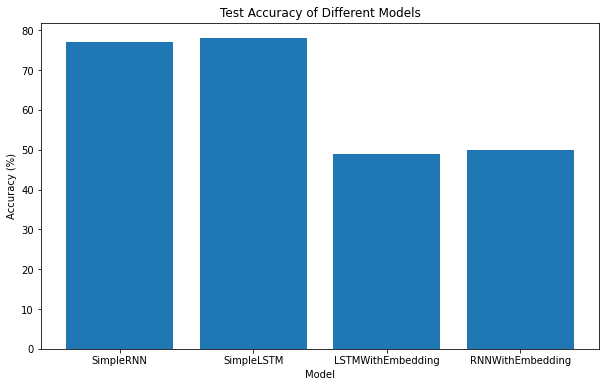

In [38]:
import matplotlib.pyplot as plt
#plot all accuracies
plt.figure(figsize=(10, 6))
plt.bar(['SimpleRNN', 'SimpleLSTM', 'LSTMWithEmbedding', 'RNNWithEmbedding'], [76.95,78, 49,50])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy of Different Models')
